# Transformation Methods

In [7]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false)

## Inversion Method

Let $U \sim \text{Uniform}[0, 1]$ and $F$ be the cumulative distrbution function. We have that:
$$\mathbb{P}(F^{-1}(U) \leq x) = \mathbb{P}\left(U \leq F(x)\right) = F(x)$$
Hence, the random variable $F^{-1}(U)$ has $F$ as its CDF.

Given a distribution function $f$ and its CDF $F$, and its inverse $F^{-1}$, we can generate samples from $F$ simulating samples  $U \sim \text{Uniform}[0, 1]$ and applying the transformation $F^{-1}(U)$.

Example: Exponential distribution

$$f(x) = \lambda e^{-\lambda x}$$
$$F(x) = 1 - e^{-\lambda x}$$
$$F^{-1}(x) = -\frac{1}{\lambda}\log(1 - x)$$

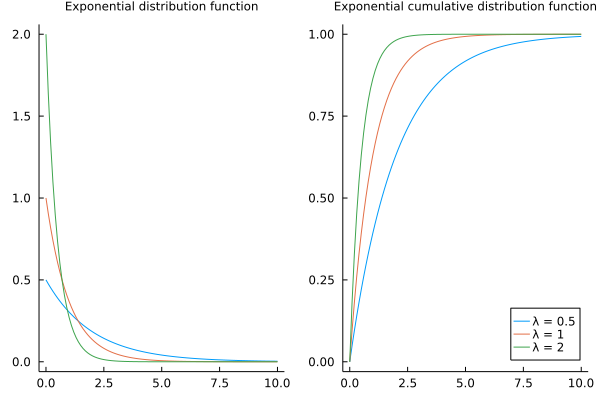

In [9]:
function f(x, λ)
   λ .* exp.(-λ .* x)
end

function F(x, λ)
    1 .- exp.(-λ .* x)
end

x = [0:0.1:10;]

plot(x, f(x, 0.5), label="λ = 0.5", 
    title="Exponential distribution function", 
    titlefontsize=8, layout=(1, 2), subplot=1, legend=false)
plot!(x, f(x, 1), label="λ = 1", subplot = 1)
plot!(x, f(x, 2), label="λ = 2", subplot = 1)

plot!(x, F(x, 0.5), label="λ = 0.5", 
    title = "Exponential cumulative distribution function", 
    titlefontsize=8, subplot = 2, legend=:bottomright)
plot!(x, F(x, 1), label="λ = 1", subplot = 2)
plot!(x, F(x, 2), label="λ = 2", subplot = 2)

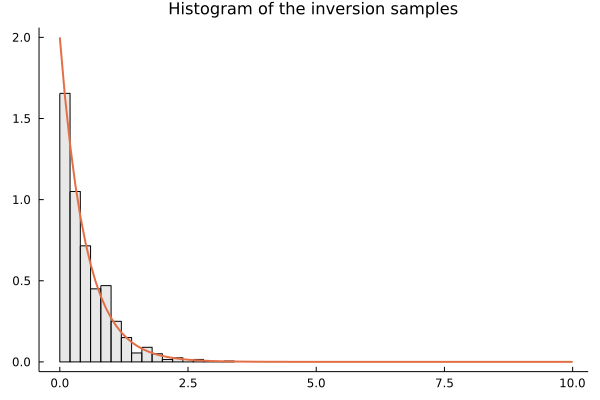

In [12]:
function inv_F(x, λ)
    - log.(1 .- x) ./ λ
end

function inv_exp_sample(;n=1000, λ=1)
    u = rand(Uniform(), n)
    y = inv_F(u, λ)
    y
end

λ = 2
y = inv_exp_sample(λ=λ)
histogram(
    y, fillalpha=0.5, normed=true, 
    title="Histogram of the inversion samples",
    titlefontsize=11
)
plot!(x, f(x, λ), width=2)

## Box-Muller for Generating Normals

The goal is to obtain samples from a Normal distribution, by having access to samples from the Uniform distribution only.

We use the following relationship:

If $\theta \sim U[0, 2\pi]$ and $R^2 \sim \text{Exp}(\frac{1}{2})$, under the transformation:
$$X_1 = R \cdot \cos(\theta) \quad X_2 = R \cdot \sin(\theta)$$
We have that $X_1, X_2 \sim N(0,1)$.

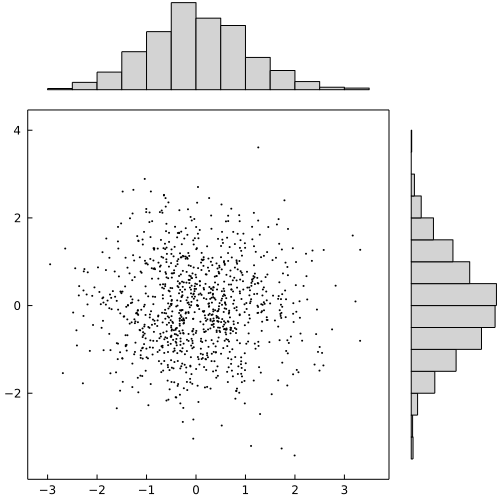

In [13]:
n = 1000
R = sqrt.(inv_exp_sample(n=n, λ=0.5))
θ = rand(Uniform(), n) * 2 * π

X1 = R .* cos.(θ)
X2 = R .* sin.(θ)

layout = @layout [a            _
                  b{0.8w,0.8h} c]

plot(layout=layout, link=:both, size=(500, 500), margin=-10Plots.px)
scatter!(X1, X2, subplot=2, framestyle=:box)
histogram!([X1 X2], subplot=[1 3], orientation=[:v :h], framestyle=:none)

## Rejection Sampling

#### Motivation

Rejection sampling is similar to the raindrop experiment. In its simplest from we essentially want to sample from "the area under the curve". Imagine graphing the density function of a random variable onto a large rectangular board. The raindrops fall uniformly on the board. We remove all the points that are outside the area under the curve. The remaining points will be distributed uniformly within the area under the curve, and the $x$-positions of these points will be distributed according to the random variable's density. This is because, the points are most likelly to fall on the area with the largest probability density.

#### Sampling from the Beta distribution

$$f(x) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}x^{a-1}(1-x)^{b-1}, \quad \text{for }0<x<1$$

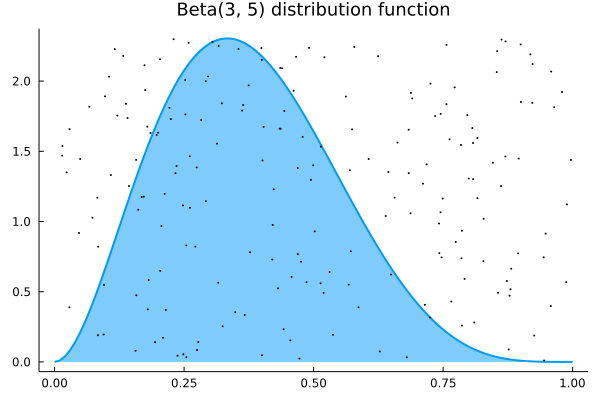

In [16]:
a = 3
b = 5
d = Beta(a,b)
x_M = (a - 1) / (a + b - 2)
M = pdf.(d, x_M)

x = [0:0.01:1;]
n = 200
X = rand(Uniform(), n)
Y = rand(Uniform(0, M), n) 
plot(x, pdf.(d,x), fillrange=[zeros(length(x)), pdf.(d,x)], fillcolor = 1, 
    fillalpha=0.5, title="Beta($a, $b) distribution function", 
    width=2, titlefontsize=12)
scatter!(X, Y)

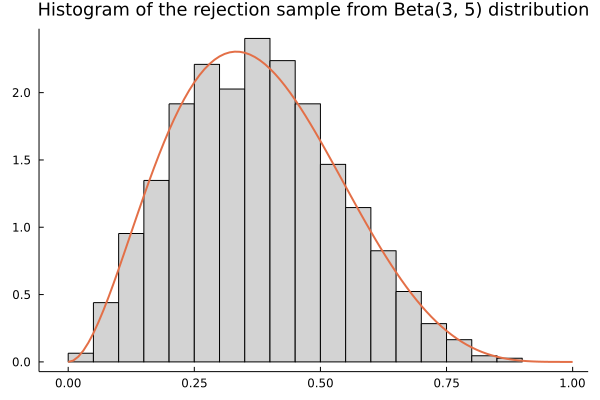

In [18]:
function rej_beta_sample(;a, b, n=1000)
    d = Beta(a,b)
    x_M = (a - 1) / (a + b - 2)
    M = pdf.(d, x_M)
    X = rand(Uniform(), n)
    Y = rand(Uniform(0, M), n)
    accept = Y .< pdf.(d, X)
    X[accept]
end

histogram(rej_beta_sample(n=5000, a=a, b=b), bins=30, normed=true)
plot!(x, pdf.(d,x), 
    title="Histogram of the rejection sample from Beta($a, $b) distribution", 
    width=2, titlefontsize=12)

### The Rejection sampling algorithm.

It is not always possible, to "draw a box" around our desired the density function. Instead, we can bound the density $f(x)$ by $M \cdot g(x)$, where $g$ is another distribution function (from which we know how to sample), and $M$ a scaling constant.



**Algorithm:** Given the target distribution $f$, proposal $g$ and a constant $M$, s.t. $f(x) < M \cdot g(x)$ for all $x \in \text{supp}(f(x))$:
1. Draw $X \sim g$
2. Accept $X$ as a sample from $f$ with probability
$$\frac{f(X)}{M \cdot g(X)}$$
3. Go back to step 1.

#### Sampling from Normal with Cauchy proposal

Target distribution: Normal(0,1)
$$f(x) = \frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{x^2}{2}\right)}$$

Proposal distribution: Cauchy
$$g(x) = \frac{1}{\pi(1+x^2)}$$

Bounding constant s.t. $f(x) \leq Mg(x)$ is $M = \sqrt{2\pi}\exp{(-1/2)}$.

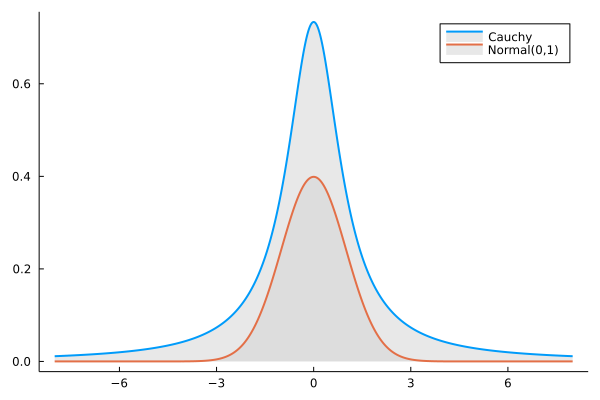

In [19]:
dg = Cauchy()
df = Normal()
n = 200
X = rand(dg, n)

x = [-8:0.01:8;]
plot(x, M*pdf.(dg,x), width=2, fillrange=[zeros(length(x)) M*pdf.(df,x)], 
    fillalpha=0.5, label="Cauchy", legend=:topright)
plot!(x, pdf.(df,x), width=2, fillrange=[zeros(length(x)) pdf.(df,x)], 
    fillalpha=0.5, label="Normal(0,1)")

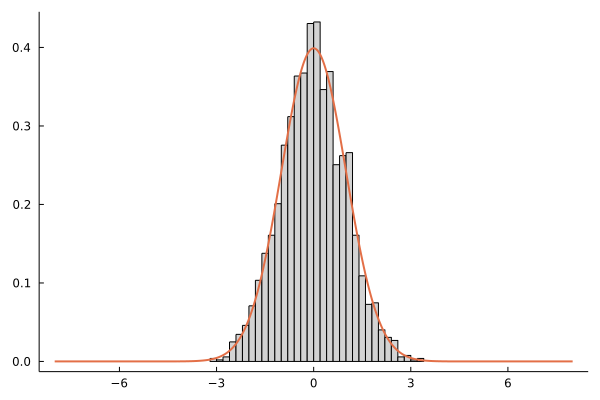

In [20]:
function rej_normal_sample(n=4000)
    M = sqrt(2 * pi) * exp(-0.5)
    dg = Cauchy()
    df = Normal()
    X = rand(dg, n)
    U = rand(Uniform(), n)
    prob = pdf.(df, X) ./ (M * pdf.(dg, X))
    accept = U .< prob
    X[accept]
end

X = rej_normal_sample()
histogram(X, normed=true)
plot!(x, pdf.(df,x), width=2, label="Normal(0,1)")

## Importance Sampling

Importance sampling is based on the idea of rejection sampling. Yet, instead of rejecting or accepting the samples, we assign to each sample a weight. Samples which are more likely to come from the target distribution are assigned a higher weight, and samples which are less likely, a lower weight. As the result, we do not obtain samples which are distributed according to the target distribution, but we can however give an estimate of its mean $\mu$. 

**Algorithm**
Let $g$ be s.t. $\text{supp}(g) \supset \text{supp}(f)$.
For $i$ in $1, \ldots, n$:
1. Draw $X_i \sim g$
2. Set $w(X_i) = \frac{f(X_i)}{g(X_i)}$

Return:
$$\hat{\mu} = \frac{\sum_iX_iw(X_i)}{\sum_iw(X_i)}$$

### Example: Importance Sampling - choice of proposal

Goal: find the estimate of $\mathbf{E}_f|X|$, where $X \sim t_3$ ($t$-distribution with 3 dergrees of freedom)

Proposal distributions:
1. $g_1(x) = t_3$
3. $g_2(x) = t_1$
2. $g_3(x) = N(0,1)$

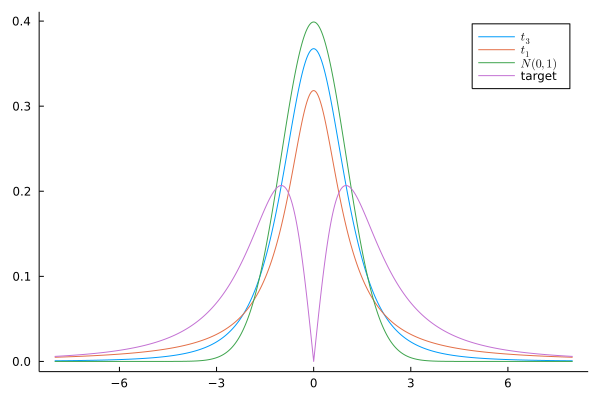

In [22]:
g1 = TDist(3)
g2 = TDist(1)
g3 = Normal()
df = TDist(3)

x = [-8:0.01:8;]
plot(x, [pdf.(g1, x), pdf.(g2, x), pdf.(g3,x), abs.(x) .* pdf.(df, x)], 
    label = [L"t_3" L"t_1" L"N(0,1)" "target"], legend=:topright)

In [23]:
function imp_sample(;g, n=1500)
    X = rand(g, n)
    W = pdf.(df, X) ./ pdf.(g, X)
    est  = cumsum(abs.(X) .* W )./ [1:1:n;]
    est
end

est_df = DataFrame(
    est1 = imp_sample(g=g1),
    est2 = imp_sample(g=g2),
    est3 = imp_sample(g=g3)
)

est_df[!, "max_est1"] = est_df[!, "est1"]
est_df[!, "max_est2"] = est_df[!, "est2"]
est_df[!, "max_est3"] = est_df[!, "est3"]

est_df[!, "min_est1"] = est_df[!, "est1"]
est_df[!, "min_est2"] = est_df[!, "est2"]
est_df[!, "min_est3"] = est_df[!, "est3"]

for i in range(1, 100)
    est1 = imp_sample(g=g1)
    est2 = imp_sample(g=g2)
    est3 = imp_sample(g=g3)
    
    est_df[!, "max_est1"] = max.(est_df[!, "max_est1"], est1)
    est_df[!, "max_est2"] = max.(est_df[!, "max_est2"], est2)
    est_df[!, "max_est3"] = max.(est_df[!, "max_est3"], est3)
    
    est_df[!, "min_est1"] = min.(est_df[!, "min_est1"], est1)
    est_df[!, "min_est2"] = min.(est_df[!, "min_est2"], est2)
    est_df[!, "min_est3"] = min.(est_df[!, "min_est3"], est3)
end

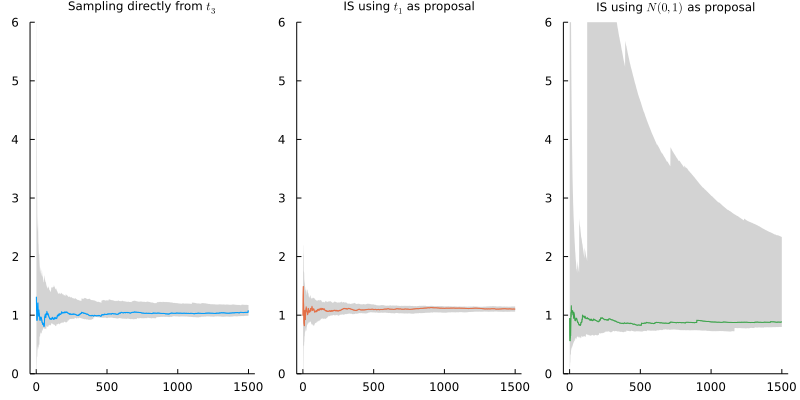

In [36]:
default(titlefontsize=8)
@df est_df plot(
    [:est1 :est1], fillrange=[:min_est1 :max_est1], layout = (1, 3), 
    size = (800, 400), subplot=1,  ylim = (0, 6),
    title="Sampling directly from "*L"t_3", color=1
)
@df est_df plot!(
    [:est2 :est2], fillrange=[:min_est2 :max_est2], subplot=2,
    title = "IS using "*L"t_1"*" as proposal", color=2, ylim = (0, 6),
)
@df est_df plot!(
    [:est3 :est3], fillrange=[:min_est3 :max_est3], subplot=3,
    title = "IS using "*L"N(0,1)"*" as proposal", color=3,  ylim = (0, 6),
)

We observe that sampling using the $t_1$ proposal has the lowest variance. Notably the variance is lower, than sampling directly from $t_3$.
This is known as **superefficiency** of the importance sampling.

---
Bibliography:
1. ST407 Monte Carlo Methods - Lecture notes by Adam M. Johansen (University of Warwick)